# Assignment 6

In this assignment, you are expected to write your own collision avoidance system (CAS).
You are given a lot of freedom in order to accomplish this task. The implementation you see below is merely _one_ way in which this can be done.

Your objective is to find a CAS policy $\pi(s) \rightarrow a$ which minimizes collisions and alerts. We want a safe system (few collisions) but we also do not want to alert when we do not need to (few alerts).

Collision avoidance systems will be judged according to a _cost function_ $J(\text{encounter}) \rightarrow \mathbb{R}$. 
We want to minimize the expected penalty accumulated by the CAS.
Formally:

$$\min_\pi \mathbb{E}\left[J_\pi(\text{encounter})\right]$$

What this means is that we want the policy $\pi$ which on average produces encounters with minimum penalites.
We can estimate the performance of a policy by running a large number of encounters with it and then taking the mean of the accumulated penalty.

Penalties in this assignment are computed according to:

* a penalty of 10 for issuing an advisory - only issue advisories when you need to
* a penality equal to the magnitude of the advised climb rate each time a new advisory is issued - weak climb rates are easier on the passengers
* a penalty of 50 for a reversal - a change of sign in the advisory
* a penalty of 1e5 for an near mid-air collision (NMAC) - being within 100 ft vertically or 500 ft horizontally of another plane

### What is Turned In

Write all of your code in a file structured identically to "my_cas.jl" and turn it in to Coursework.

## Milestone One: Set Up

In [31]:
using AA120Q
plotlyjs()

Plots.PlotlyJSBackend()

Here is a dataset of fully-human encounters, which you can then use to collect your own set of encounters to evaluate your Collision Avoidance System (CAS).

In [32]:
initial, traces = get_dataset("small")
encounters = pull_encounters(initial, traces, 500);

In [33]:
plot_encounter(encounters[1])   # Sample Plot

Here we're simulating trajectories using the [provided] traffic and collision avoidance system (TCAS). You will then design your own CAS (see below), and then compare the two results, to see if your model gets similar results as the standard model.

In [34]:
srand(0)
enc = rand(encounters[1], TCAS())
plot_encounter(enc)

## Milestone Two: Improving the DCAS

We have provided you with a basic CAS that you will need to improve in order to find the sweet spot between minizing collisions and alerts to the pilot. In order to improve the the DCAS, we would like you to decide whether going up or going down is better (DCAS always tells the host aircraft to fly up). Incorporate the climb rate of each aircraft and calculating whether or not you'll pass over them or below them and then decide whether to pull up or pull down.

**(Optional)** For those of you who would like more of a challenge, you can also use apredictive model to estimate what the other plane will do. This will entail modeling the problem as a Markov Decision Process. You can use POMDPs.jl to solve it. You may want to go to office hours as well if you're interesting in implementing this solution.

### Demonstrative Collision Avoidance System - (DCAS)

Here is a demonstrative collision avoidance system, which is a fully-functional out-of-the-box CAS. It will leverage the model and the AA120Q API. The two functions reset() and update() are implemented here. Use it as a starting point to design your own CAS.

The model will issue an Advisory (or none) at each timestep. Issuing ADVISORY_NONE or your previous advisory is equivalent to issuing no advisory.

In [35]:
type DemoCAS <: FullyObservableCollisionAvoidanceSystem
    range_threshold::Float64
    last_advisory::Advisory
    DemoCAS(range_threshold::Float64, last_advisory::Advisory=ADVISORY_NONE) = new(range_threshold, last_advisory)
end

A reset function to start it anew

In [12]:
function AA120Q.reset!(dcas::DemoCAS)
    dcas.last_advisory = ADVISORY_NONE
    dcas
end

reset! (generic function with 3 methods)

The update function issues an advisory

In [13]:
function AA120Q.update!(dcas::DemoCAS, s1::AircraftState, s2::AircraftState, params::EncounterSimParams)

    # pull TCAS observations
    x1, y1, h1 = s1.e, s1.n, s1.h
    x2, y2, h2 = s2.e, s2.n, s2.h

    range = norm([(x2 - x1), (y2 - y1)]) # range [ft]
    relalt = abs(h1 - h2) # relative altitude [ft]

    # test for activation
    if is_no_advisory(dcas.last_advisory) && range < dcas.range_threshold
        dcas.last_advisory = Advisory(CLIMB_RATE_MAX) # climb!
    end
        
    dcas.last_advisory
end

update! (generic function with 5 methods)

You can now simulate trajectories with your custom CAS...


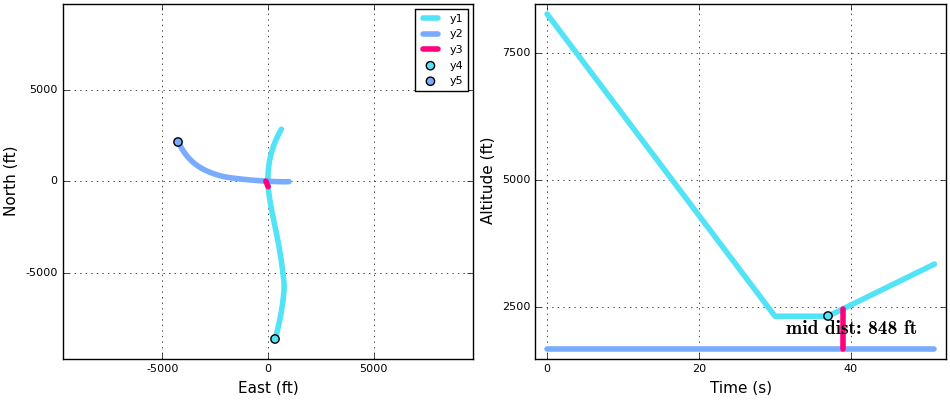

In [14]:
srand(0)
enc = rand(encounters[1], DemoCAS(1000.0))
plot_encounter(enc)

## Milestone Three: Pull Evaluation Metrics

Use `evaluate` to report the number of advisories and near midair collisions (NMACs). Remember that a good safety system will minimize both the number of collisions and the number of alerts. We will measure performance based on the average cost per trajectory, `CASEval.normalized`. Try to minimize it!

In [22]:
# run every encounter once
evaluate(DemoCAS(1000.0), encounters)

CASEval(n_encounters: 3, n_advisories: 3, n_NMACs: 0, penalty: 400.00, normalized: 133.33)

In [23]:
# randomly sample 50 encounters from `encounters`
evaluate(DemoCAS(1000.0), encounters, 50)

CASEval(n_encounters: 50, n_advisories: 50, n_NMACs: 0, penalty: 6666.67, normalized: 133.33)